In [1]:
import dipole_module
import numpy as np
from io import StringIO
import matplotlib.pyplot as plt
import joblib
import os
import time
from tqdm import tqdm

#from sklearn.ensemble import RandomForestRegressor
#from sklearn.metrics import mean_squared_error, r2_score
#from sklearn.model_selection import train_test_split
#from sklearn.preprocessing import StandardScaler
#from sklearn.decomposition import PCA

In [2]:
#The model was trained using these r-values in [1/GeV]. You need to define your dipole on this r-grid:
r_values = [
    1.01000000e-06, 1.21200000e-06, 1.45440000e-06, 1.74528000e-06,
    2.09433600e-06, 2.51320320e-06, 3.01584384e-06, 3.61901261e-06,
    4.34281513e-06, 5.21137816e-06, 6.25365379e-06, 7.50438454e-06,
    9.00526145e-06, 1.08063137e-05, 1.29675765e-05, 1.55610918e-05,
    1.86733102e-05, 2.24079722e-05, 2.68895666e-05, 3.22674799e-05,
    3.87209759e-05, 4.64651711e-05, 5.57582053e-05, 6.69098464e-05,
    8.02918157e-05, 9.63501788e-05, 1.15620215e-04, 1.38744257e-04,
    1.66493109e-04, 1.99791731e-04, 2.39750077e-04, 2.87700092e-04,
    3.45240111e-04, 4.14288133e-04, 4.97145760e-04, 5.96574911e-04,
    7.15889894e-04, 8.59067873e-04, 1.03088145e-03, 1.23705774e-03,
    1.48446928e-03, 1.78136314e-03, 2.13763577e-03, 2.56516292e-03,
    3.07819551e-03, 3.69383461e-03, 4.43260153e-03, 5.31912184e-03,
    6.38294620e-03, 7.65953544e-03, 9.19144253e-03, 1.10297310e-02,
    1.32356772e-02, 1.58828127e-02, 1.90593752e-02, 2.28712503e-02,
    2.74455003e-02, 3.29346004e-02, 3.95215205e-02, 4.74258246e-02,
    5.69109895e-02, 6.82931874e-02, 8.19518249e-02, 9.83421898e-02,
    1.18010628e-01, 1.41612753e-01, 1.69935304e-01, 2.03922365e-01,
    2.44706838e-01, 2.93648205e-01, 3.52377846e-01, 4.22853416e-01,
    5.07424099e-01, 6.08908919e-01, 7.30690703e-01, 8.76828843e-01,
    1.05219461e+00, 1.26263353e+00, 1.51516024e+00, 1.81819229e+00,
    2.18183075e+00, 2.61819690e+00, 3.14183628e+00, 3.77020353e+00,
    4.52424424e+00, 5.42909308e+00, 6.51491170e+00, 7.81789404e+00,
    9.38147285e+00, 1.12577674e+01, 1.35093209e+01, 1.62111851e+01,
    1.94534221e+01, 2.33441065e+01, 2.80129278e+01, 3.36155134e+01,
    4.03386161e+01, 4.84063393e+01, 5.80876071e+01, 6.97051286e+00,
    8.36461543e+00
]

r = np.array(r_values)

#Function to load the trained model
def load_models():
    try:
        # Load scaler and model from file
        filename_scaler = 'scaler-xList-full.joblib'
        filename_pca = 'pca_model-xList-full.joblib'
        filename_models = 'rcBK-RF-xList-full.joblib'

        Scalers = joblib.load(filename_scaler)
        PCA_models = joblib.load(filename_pca)
        RF_models = joblib.load(filename_models)
        
        return Scalers, PCA_models, RF_models
    except Exception as e:
        print(f"Error loading models: {e}")
        return None
    
#Function to interpolate in the target x value
def interpolator(x):
    #array of x values
    exponent_values = np.linspace(-6, -2, 9)
    x_values = 10.**(exponent_values)  
    x_values_arr = np.array(x_values)
    
    insert_index = np.searchsorted(x_values_arr, x)
    adjacent_values = x_values_arr[max(0, insert_index - 1):insert_index + 1]

    imp = [insert_index - 1, insert_index]
    frac = (adjacent_values[1]-x)/(adjacent_values[1]-adjacent_values[0])
    
    return imp, frac

#Function that will predict the x-evolved function given the input function, target x value, and C^2 parameter
def predict(input_function, x, C2):
    
    new_input_function = np.append(input_function, C2)
    
    imp, frac = interpolator(x)
    
    # Standardize the data
    scaler = Scalers[imp[0]]
    X_val_standardized_0 = scaler.transform([new_input_function])
    scaler = Scalers[imp[1]]
    X_val_standardized_1 = scaler.transform([new_input_function])

    # Apply PCA to reduce dimensionality
    pca = PCA_models[imp[0]]
    X_val_pca_0 = pca.transform(X_val_standardized_0)
    pca = PCA_models[imp[1]]
    X_val_pca_1 = pca.transform(X_val_standardized_1)
    
    #Predict on the fly:
    predicted_output_values = [RF_models[imp[0]].predict(X_val_pca_0)[0], RF_models[imp[1]].predict(X_val_pca_1)[0]]

    output_values = (1.-frac)*predicted_output_values[1] + (frac)*predicted_output_values[0]

    return output_values



In [3]:
#This function reads in the dipole from file 'file' at x_Bjorken 'xbj'
#It uses Heikki's dipole amplitude code to extract the r dependent dipole
#at xbj doing the required interpolations
def read_dipole(file, xbj):
    try:
        if os.path.exists(file):  # Check if the file exists
            try:
                result = dipole_module.dipole_amplitude(file, xbj)
                lines = result.strip().split('\n')

                # Initialize c2_value
                c2_value = None

                # Read C2 from first line
                if lines and lines[0].startswith("#"):
                    c2_value = float(lines[0].split()[1])

                # Remove the first line
                if lines:
                    lines = lines[1:]
        
                data = [list(map(float, line.split())) for line in lines]
                result_array = np.array(data).T
                #print(c2_value)
                return result_array, c2_value
            except Exception as e:
                # Handle the exception and print an error message
                print(f"Error: {str(e)}")
        else:
            print(f"File {file} does not exist.")
            return None, None  # Return None values if the file doesn't exist
    except Exception as e:
        print(f"An error occurred while processing {file} with xbj={xbj}: {e}")
        return None, None  # Return None values in case of an error

    
# Folder containing data files
data_folder = "data/test_C2/"

# Dynamically list all files in the folder
file_names = [os.path.join(data_folder, file) for file in os.listdir(data_folder) if os.path.isfile(os.path.join(data_folder, file))]

# Number of files in the folder
max_files = len(file_names)

In [6]:
# Test the function and handle the None case
result = load_models()
if result is not None:
    Scalers, PCA_models, RF_models = result
    print("Models loaded.")
    # Continue with further processing
else:
    print("Failed to load models. Check the error message above for details.")

Models loaded.


In [4]:
exponent_values = np.linspace(-6, -2, 9)
x_values = 10.**(exponent_values)  

#Initialize initial data array
initial_data = []
 
xdim = len(x_values)
print("Number of x values =",xdim)

target_data = []

for i in range(xdim):
    #Set target x value
    xbj_target = x_values[i]
    target_data_aux = []
    #count = 0
    for file in tqdm(file_names, desc="Loading training and validation data", unit="file"):
        #print(file)
        #print("x value =",xbj_target)
        result_array, c2_value = read_dipole(file, xbj_target)
        if i == xdim-1:
            # Append c2_value to result_array[1]
            target_data_aux.append(result_array[1])
            new_result_array = np.append(result_array[1], c2_value)
            initial_data.append(new_result_array)
        else:
            target_data_aux.append(result_array[1])
       # count = count + 1
        #if count >= 20:
         #   break
    target_data.append(np.array(target_data_aux))
   
            
input_values = np.vstack(initial_data)

r = result_array[0]
print(r)
print(len(target_data))

Number of x values = 9


Loading training and validation data: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 237.98file/s]

[1.01000000e-06 1.21200000e-06 1.45440000e-06 1.74528000e-06
 2.09433600e-06 2.51320320e-06 3.01584384e-06 3.61901261e-06
 4.34281513e-06 5.21137816e-06 6.25365379e-06 7.50438454e-06
 9.00526145e-06 1.08063137e-05 1.29675765e-05 1.55610918e-05
 1.86733102e-05 2.24079722e-05 2.68895666e-05 3.22674799e-05
 3.87209759e-05 4.64651711e-05 5.57582053e-05 6.69098464e-05
 8.02918157e-05 9.63501788e-05 1.15620215e-04 1.38744257e-04
 1.66493109e-04 1.99791731e-04 2.39750077e-04 2.87700092e-04
 3.45240111e-04 4.14288133e-04 4.97145760e-04 5.96574911e-04
 7.15889894e-04 8.59067873e-04 1.03088145e-03 1.23705774e-03
 1.48446928e-03 1.78136314e-03 2.13763577e-03 2.56516292e-03
 3.07819551e-03 3.69383461e-03 4.43260153e-03 5.31912184e-03
 6.38294620e-03 7.65953544e-03 9.19144253e-03 1.10297310e-02
 1.32356772e-02 1.58828127e-02 1.90593752e-02 2.28712503e-02
 2.74455003e-02 3.29346004e-02 3.95215205e-02 4.74258246e-02
 5.69109895e-02 6.82931874e-02 8.19518249e-02 9.83421898e-02
 1.18010628e-01 1.416127

1e-05
0.1


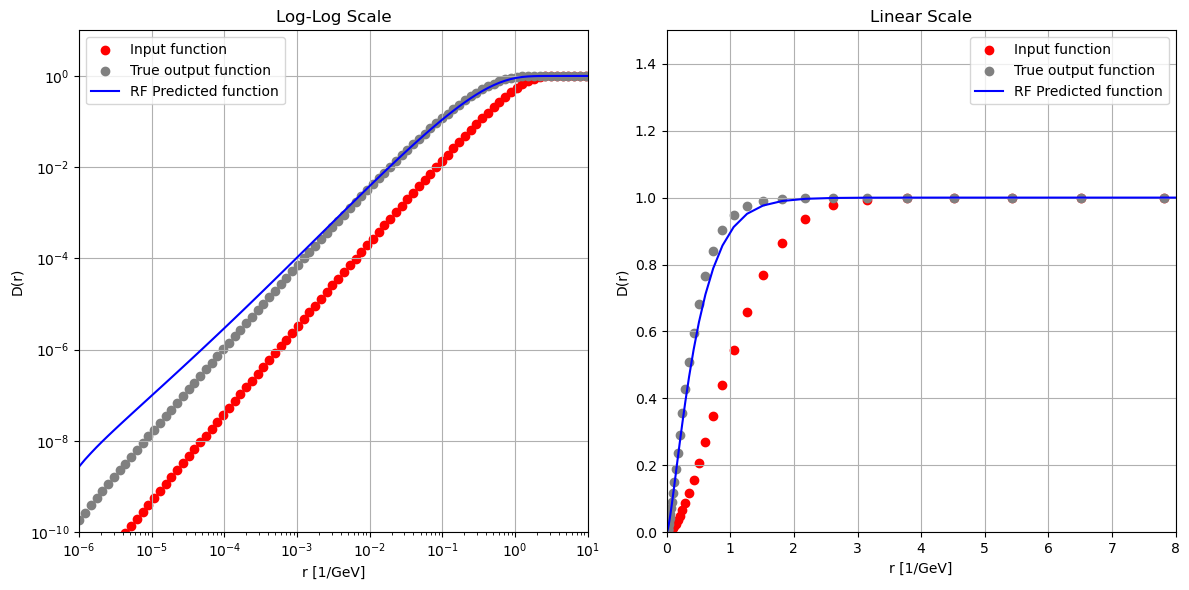

In [7]:
i = 1
    
# Sample a value logarithmically
log_lower_bound = np.log(1e-4)
log_upper_bound = np.log(0.01)
log_sample = np.random.uniform(log_lower_bound, log_upper_bound)
# Convert the log value to the original scale
x = 0.00001 #np.exp(log_sample)

print(x)

imp, frac = interpolator(x)

output_values_0 = np.vstack(target_data[imp[0]])
output_values_1 = np.vstack(target_data[imp[1]])

true_values = (1.-frac)*output_values_1[i] + (frac)*output_values_0[i]

# Standardize the data
scaler = Scalers[imp[0]]
X_val_standardized_0 = scaler.transform([input_values[i]])
scaler = Scalers[imp[1]]
X_val_standardized_1 = scaler.transform([input_values[i]])

# Apply PCA to reduce dimensionality
pca = PCA_models[imp[0]]
X_val_pca_0 = pca.transform(X_val_standardized_0)
pca = PCA_models[imp[1]]
X_val_pca_1 = pca.transform(X_val_standardized_1)

#Predict on the fly:
predicted_output_values = [RF_models[imp[0]].predict(X_val_pca_0)[0], RF_models[imp[1]].predict(X_val_pca_1)[0]]

output_values = (1.-frac)*predicted_output_values[1] + (frac)*predicted_output_values[0]

# Plot with log-log scale
plt.figure(figsize=(12, 6))

print(input_values[i][101])

# Plot with log-log scale
plt.subplot(1, 2, 1)
plt.xlim(0.000001, 10.) 
plt.ylim(1e-10, 10.)
plt.scatter(r, input_values[i][:101], color='red', label='Input function')
plt.scatter(r, true_values, color='gray', label='True output function')
plt.plot(r, output_values, color='blue', label='RF Predicted function')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('r [1/GeV]')
plt.ylabel('D(r)')
plt.title('Log-Log Scale')
plt.legend()
plt.grid(True)

# Plot with linear scale
plt.subplot(1, 2, 2)
plt.xlim(0, 8.) 
plt.ylim(0, 1.5) 
plt.scatter(r, input_values[i][:101], color='red', label='Input function')
plt.scatter(r, true_values, color='gray', label='True output function')
plt.plot(r, output_values, color='blue', label='RF Predicted function')
plt.xlabel('r [1/GeV]')
plt.ylabel('D(r)')
plt.title('Linear Scale')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


In [28]:
#Define IPSat
Nc=3.
alphas=0.1

def xg(x):
    return 2.308*x**(-0.058)*(1.-x)**5.6

def Tp(b,Bp):
    return 1./2./Bp*np.exp(-b**2./2./Bp)

def F(x,r,b,Bp):
    return np.pi**2./2./Nc*(r**2.)*alphas*xg(x)*Tp(b,Bp)

def dipole(x, r, b, Bp):
    return (1.-np.exp(-F(x,r,b,Bp)))

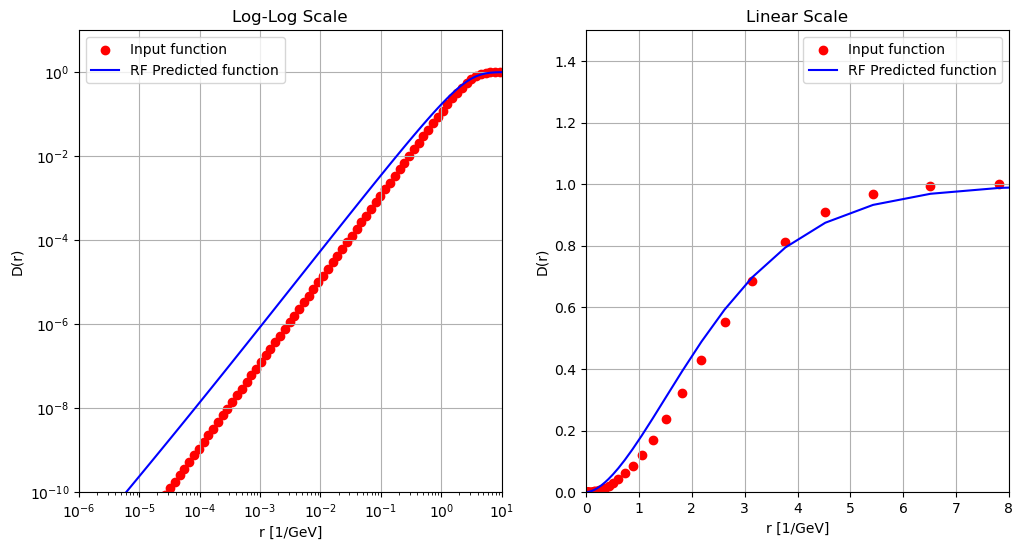

In [30]:
IPSat_input = dipole(0.01, r, 0., 2.)
output_values = predict(IPSat_input, 0.001, 10.)

# Plot with log-log scale
plt.figure(figsize=(12, 6))

# Plot with log-log scale
plt.subplot(1, 2, 1)
plt.xlim(0.000001, 10.) 
plt.ylim(1e-10, 10.) 
plt.scatter(r, IPSat_input, color='red', label='Input function')
plt.plot(r, output_values, color='blue', label='RF Predicted function')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('r [1/GeV]')
plt.ylabel('D(r)')
plt.title('Log-Log Scale')
plt.legend()
plt.grid(True)

# Plot with linear scale
plt.subplot(1, 2, 2)
plt.xlim(0, 8.) 
plt.ylim(0, 1.5) 
plt.scatter(r, IPSat_input, color='red', label='Input function')
plt.plot(r, output_values, color='blue', label='RF Predicted function')
plt.xlabel('r [1/GeV]')
plt.ylabel('D(r)')
plt.title('Linear Scale')
plt.legend()
plt.grid(True)